In [1]:
from IPython.core.display import display, HTML; display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload 
%autoreload 2

In [387]:
import load_data
import math, pandas as pd, numpy as np, time,winsound, warnings, more_itertools, os, itertools, scipy.stats, scipy, sklearn.decomposition, scipy.io as scyio, matplotlib.pyplot as plt
RAW_DATA_PATH = raw_data_path = 'C:\\Users\\Darby\\PycharmProjects\\NeuroHack2018\\RawData'
PRO_DATA_PATH = pro_data_path = 'C:\\Users\\Darby\\PycharmProjects\\NeuroHack2018\\ProData'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import util
import matlab.engine
# /c/Program Files/MATLAB/R2017a/extern/engines/python
# http://www.shaneahmed.com/2017/08/running-matlab-code-from-python.html
mat_eng = matlab.engine.start_matlab() 
subject = str(2)

In [3]:
""" Load Dataset """
dat_dict = scyio.loadmat(os.path.join(PRO_DATA_PATH, 'dat' + subject), squeeze_me=True)
dat = pd.DataFrame(dat_dict['datStruct'])

In [4]:
""" Get our neuron PD. Descibes types index and goodness of each neuron"""
type_pd = pd.read_csv(os.path.join(PRO_DATA_PATH, 'type' + subject), header=None)
type_pd.columns = ['cell_int']
def int_to_cell_type(cell_int):
    if cell_int == 0: return 'motor'
    elif cell_int == 1: return 'dorsal'
    elif cell_int == 2: return 'ventral'
    else: raise ValueError()
type_pd = type_pd.assign(cell_type=type_pd['cell_int'].apply(int_to_cell_type))

good_neuron_pd = pd.DataFrame(dat_dict['goodNeurons'])
good_neuron_pd.columns = ['good']
good_neuron_pd = good_neuron_pd.assign(cell_index=range(len(type_pd)))
good_neuron_pd = good_neuron_pd.assign(good=good_neuron_pd.good ==1 )
assert len(good_neuron_pd) == len(type_pd)
neuron_pd = pd.concat([type_pd, good_neuron_pd], axis=1, join='inner')
del good_neuron_pd, type_pd

In [363]:
""" Add a good motor neurons column.  It is 46 x 15000 """
motor_neuron_indexes = list(neuron_pd[(neuron_pd.cell_type == 'motor') & (neuron_pd.good)].cell_index)
dorsal_neuron_indexes = list(neuron_pd[(neuron_pd.cell_type == 'dorsal') & (neuron_pd.good)].cell_index)
ventral_neuron_indexes = list(neuron_pd[(neuron_pd.cell_type == 'ventral') & (neuron_pd.good)].cell_index)

def filter_for_cell_type(data_array, cell_indexes): 
    return data_array[cell_indexes, :]
dat = dat.assign(motor_neurons=dat['neuralDat'].apply(filter_for_cell_type, args=(motor_neuron_indexes,)))
if subject == '2': assert dat['motor_neurons'].iloc[0].shape[0] == 46  #(46, 1500)
dat = dat.assign(dorsal_neurons=dat['neuralDat'].apply(filter_for_cell_type, args=(dorsal_neuron_indexes,)))
dat = dat.assign(ventral_neurons=dat['neuralDat'].apply(filter_for_cell_type, args=(ventral_neuron_indexes,)))

In [439]:
""" Add reward PD """
# He's too successful to use this as a good learning metric. Let's try peak velocity instead
reward_pd = pd.read_csv(os.path.join(PRO_DATA_PATH, 'reach_reward' + subject), header=None, delimiter='\t').T
reward_pd.columns = ['reward_bool']
reward_pd = reward_pd.assign(reward_rate = reward_pd.reward_bool.rolling(window=5, win_type='boxcar', center=True).sum())

In [553]:
smoothed_peak_amp = pd.Series(dat['amp']).rolling(window=4, win_type='boxcar', center=True).mean()

In [369]:
""" Add Spike Binning """
def do_binning(data_array, bin_size):
    assert data_array.shape[1] % bin_size == 0, data_array.shape
    spike_sums = []
    for i in range(0, data_array.shape[1], bin_size):
        indexes = range(i, i + bin_size)
        sub_array = data_array[:, indexes]
        sub_array_sum = sub_array.sum(axis=1)
        spike_sums.append(sub_array_sum)
    return np.asarray(spike_sums).T
# Test For do_binning
bin_size = 250
x = np.asarray([range(9)] * 4)
do_binning(x, bin_size=3)
dat = dat.assign(**{'motor_neuron_bin' + str(bin_size): dat['motor_neurons'].apply(do_binning, bin_size=bin_size), 
                    'ventral_neuron_bin' + str(bin_size): dat['ventral_neurons'].apply(do_binning, bin_size=bin_size), 
                    'dorsal_neuron_bin' + str(bin_size): dat['dorsal_neurons'].apply(do_binning, bin_size=bin_size)})
assert dat['motor_neuron_bin' + str(bin_size)].iloc[0].shape[1] == dat['motor_neurons'].iloc[0].shape[1] / bin_size

In [404]:
""" Assertions - Check Average Firing Rates"""
avgs = []
for reach_index in range(len(dat['motor_neurons'])):
    x = np.mean(dat['motor_neurons'].iloc[reach_index], axis=1)
    avgs.append(x)
avgs = np.stack(avgs, axis=1)
    #     avgs = np.mean(dat['motor_neurons'].iloc[reach_index], axis=1) , axis=1)
# np.mean(avgs, axis=1) * 1000

In [407]:
""" Combine All Trials """
### Treat each bin as independent.
def stack_numpy_pd(series):
    """ Iterates over our series and returns a single numpy array,
        appending the numpy array o"""
    np_arrs = []
    for index in range(len(series)):
        # print('b', series.iloc[index].shape)
        avg = np.mean(series.iloc[index], axis=1)
        # print('a', avg.shape)
        np_arrs.append(avg)
    np_arrs = np.stack(np_arrs, axis=1)

    return np.asarray(np_arrs)
X_motor   = stack_numpy_pd(dat['motor_neuron_bin' + str(bin_size)]).T    # Num Reaches, Num Neurons
X_ventral = stack_numpy_pd(dat['ventral_neuron_bin' + str(bin_size)]).T  # Num Reaches, Num Neurons
X_dorsal =  stack_numpy_pd(dat['dorsal_neuron_bin' + str(bin_size)]).T   # Num Reaches, Num Neurons
assert X_motor.shape[0] == X_ventral.shape[0] == X_dorsal.shape[0], X_dorsal.shape

In [430]:
signal_pd = pd.DataFrame({'motor': [pd.DataFrame(X_motor)], 'ventral': [pd.DataFrame(X_ventral)], 'dorsal': [pd.DataFrame(X_dorsal)]}, index=['raw_signal'])

In [552]:
brain_areas = ['dorsal', 'ventral', 'motor']
temp_dict = dict()
for xx in brain_areas: temp_dict[xx] = []
for ba in brain_areas:
    fa = sklearn.decomposition.FactorAnalysis(n_components=2)
    X_low = pd.DataFrame(fa.fit_transform(signal_pd[ba].loc['raw_signal']), columns = ['Factor%d' % xx for xx in range(num_factors)])
    X_low = X_low.assign(reach_index=range(len(X_low)))
    temp_dict[ba].append(X_low)
X_low_pd = pd.DataFrame(temp_dict, index=['lowD_signal'])

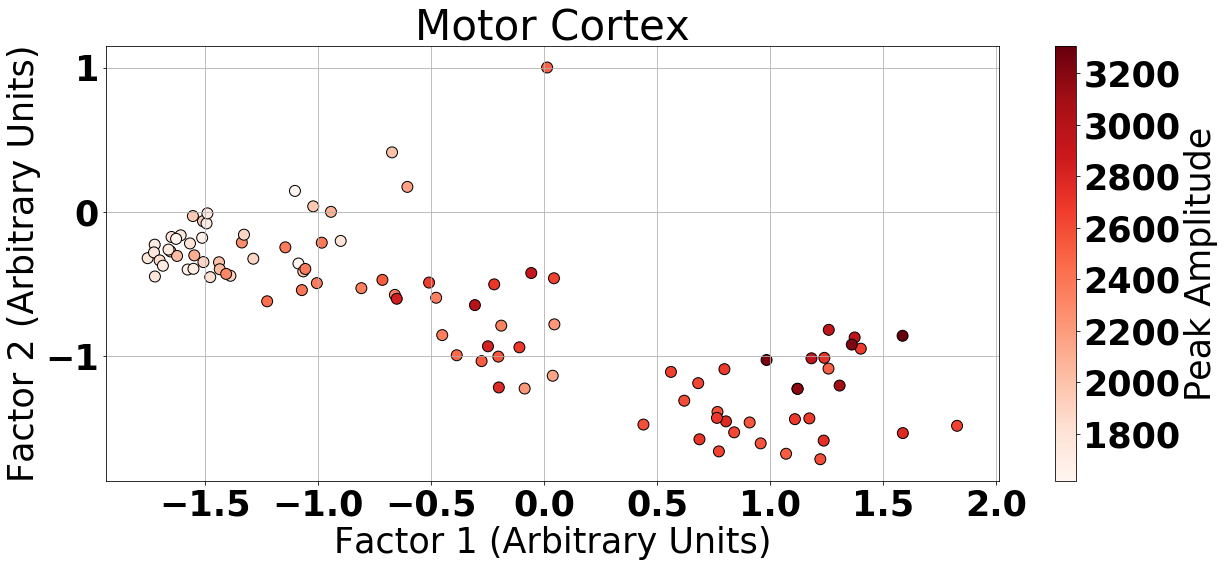

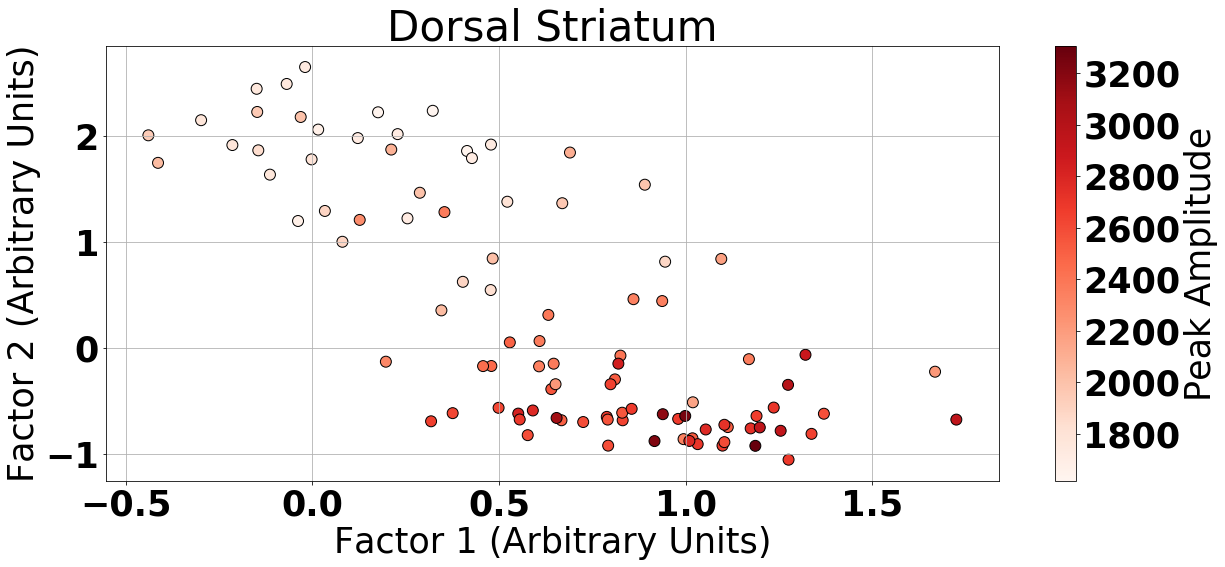

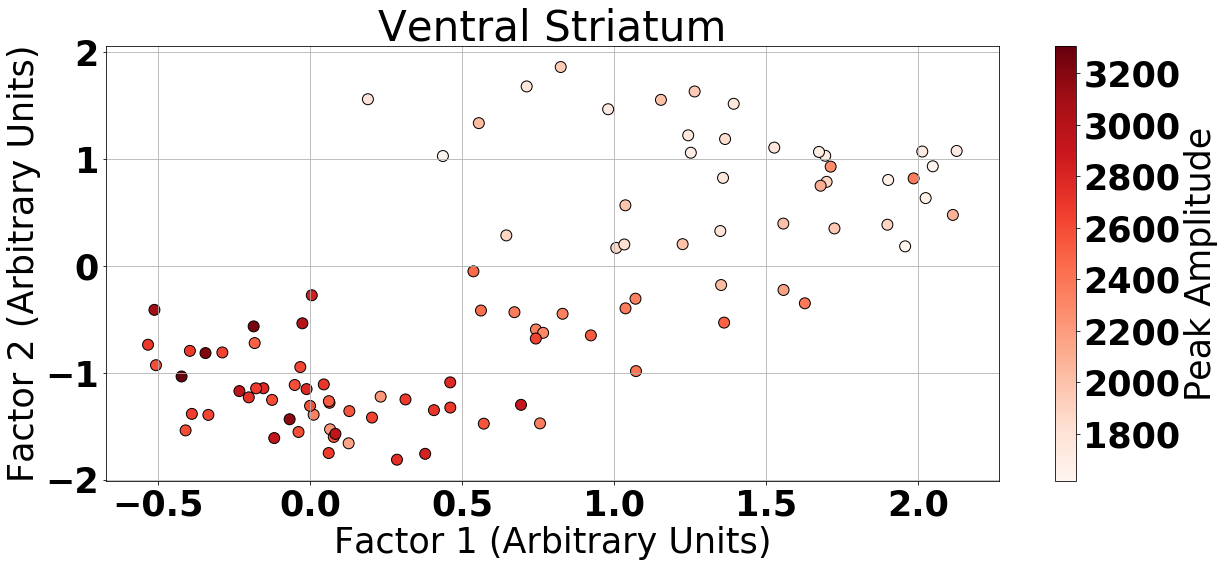

In [551]:
""" How Does our Low D signal Look across the entire experiment """
plt.rcParams.update({'font.size': 35, 'font.weight': 'bold'})
trial_cutoff = 100
ba = 'motor'
indexes = range(0, trial_cutoff)
for ba in ['motor', 'dorsal', 'ventral']:
    if ba == 'motor': 
        title = ba + ' Cortex'
    else:
        title = ba + ' Striatum'
    plt.figure(figsize=(20,8))
    plt.grid('on')
    plt.title(title.title())
    fpd = X_low_pd[ba].iloc[0]
    fpd = fpd[fpd.reach_index.isin(indexes)]
    factor0 = fpd['Factor0']
    factor1 = fpd['Factor1']
    smoothed_peak_amp_learn = smoothed_peak_amp[:trial_cutoff]
    plt.scatter(factor0, factor1, c=smoothed_peak_amp_learn, cmap='Reds', s=120, edgecolors='k')
    cbar = plt.colorbar()
    cbar.set_label('Peak Amplitude')
    plt.ylabel('Factor 2 (Arbitrary Units)')
    plt.xlabel('Factor 1 (Arbitrary Units)')
